<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_3_Estudios_cuantitativos_de_relaci%C3%B3n_estructura_actividad_(QSAR)__Similitud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Construcción de un modelo QSAR***


---
Script realizado por Raziel Cedillo-González.
Última actualización: 12-03-2024.
Contacto: brayanraziel1997@gmail.com

---

El flujo de trabajo descrito a continuación integra la experiencia y trabajo del Dr. Pat Walters, disponible en su repositorio (https://github.com/PatWalters/practical_cheminformatics_tutorials). En este script, es posible modificar el formato de entrada, los descriptores o el modelo de *machine learning* cambiando una sola línea de código. Es importante tener en cuenta que este código no reemplaza una validación rigurosa, pero proporciona un punto de partida ágil.

# ***Tabla de Contenido***
Previo a ejecutar este código se requiere el curado de la base de datos y estandarización de SMILES

- [0 - ***Instalación e importación de librerías***](#0)
- [1 - ***Lectura de archivos***](#1)
- [2 - ***Cálculo de descriptores (EFPC)***](#2)
- [3 - ***Transformación de moléculas (molfeat)***](#3)
- [4 - ***Cálculo de fingerprints***](#4)
- [5 - ***Segmentación de datos: entrenamiento y prueba***](#5)
- [6 - ***Regresión (sklearn)***](#6)
- [7 - ***Construcción y visualización del modelo***](#7)
- [8 - ***Residuales***](#8)
- [9 - ***Predicción***](#9)

<a name='0'></a>
# **Instalación e importación de librerías**

In [1]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random, subprocess, statistics
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        !pip install rdkit, pandas
        !pip install datamol # Biblioteca que proporciona utilidades y funciones para trabajar con datos moleculares, como moléculas químicas y conjuntos de datos químicos.
        !pip install molfeat # Centro de generadores de características moleculares.
        !pip install numpy
        !pip install sklearn #Biblioteca de ML, proporciona herramientas para realizar tareas comunes: clasificación, regresión, clustering y selección de modelos.
        !pip install yellowbrick #Biblioteca para visualización de ML
        pbar.update(30)
        import pandas as pd
        import datamol as dm
        from molfeat.calc import FPCalculator #Esta clase se utiliza para calcular descriptores moleculares
        from molfeat.trans import MoleculeTransformer # Esta clase se utiliza para transformar las moléculas aplicando ciertas operaciones.
        from molfeat.calc import FP_FUNCS #Esta clase se utiliza para calcular fingerprints
        pbar.update(30)
        import numpy as np
        from sklearn.model_selection import train_test_split #Se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba.
        from sklearn.ensemble import HistGradientBoostingRegressor # Es una implementación de Gradient Boosting para problemas de regresión en scikit-learn.
        from yellowbrick.regressor import prediction_error, residuals_plot # Se utiliza para (1) visualizar y (2) gráficar errores de predicción en problemas de regresión.
        #RDKit
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        PandasTools.RenderImagesInAllDataFrames(images=True) #Para visualizar moléculas
        from rdkit.Chem.Draw import IPythonConsole

        pbar.update(20)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>
##**1.** Lectura de archivos.
Se leerá el archivo (csv o xlsx) que cuente con la información de las moléculas de interés (SMILES, ID/NAME, propiedad).

Ejemplo:
```
filename ="https://raw.githubusercontent.com/PatWalters/yamc/main/data/Carbonic.smi"
df = pd.read_csv(filename,sep=" ",names=["SMILES","Name","pIC50"])
```



In [2]:
#Leer archivo
url = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/compounds_ChEMBL_G9a.csv"
df = pd.read_csv(url, index_col=0)
df

,molecule_chembl_id,SMILES,pIC50
0,CHEMBL4170225,COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...,9.301030
1,CHEMBL4162206,COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...,9.154902
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,9.045757
3,CHEMBL3109631,COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1,9.000000
4,CHEMBL5187766,COc1cc2c(=NCCN)cc[nH]c2cc1OCCCN1CCCC1,8.795880
...,...,...,...
425,CHEMBL1213958,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,3.055517
426,CHEMBL1214630,COc1cc2[nH]c(N3CCCN(C)CC3)nc(=NC3CCN(C)C3)c2cc1OC,3.040959
427,CHEMBL1214145,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,2.823909
428,CHEMBL1213959,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,2.468521


,molecule_chembl_id,SMILES,pIC50,ROMol
0,CHEMBL4170225,COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...,9.301030,
1,CHEMBL4162206,COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...,9.154902,
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,9.045757,

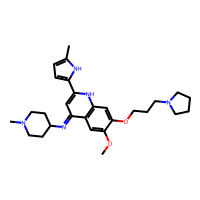
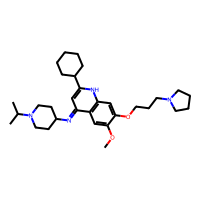
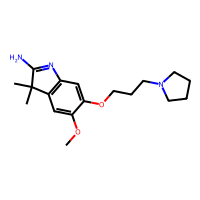

In [3]:
df_visualization=df.copy()
df_visualization['ROMol'] = df_visualization['SMILES'].apply(Chem.MolFromSmiles)
df_visualization[0:3]

<a name='2'></a>
## **2.** Selección de descriptores.
Se emplea el paquete [molfeat](https://github.com/datamol-io/molfeat), el cual tiene varios tipos de descriptores disponibles.

In [4]:
print(f'Fingerprints que se puenden calcular: {FP_FUNCS.keys()}') #Descriptores que se pueden calcular con esta libreria

Fingerprints que se puenden calcular: dict_keys(['maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'rdkit-count', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count'])


In [5]:
calc = FPCalculator("ecfp") #Cálculo de ECFP4

<a name='3'></a>

##**3.** Transformación de moléculas (molfeat).

Este objeto toma una lista de SMILES como input y regresa los descriptores seleccionados. Es muy flexible y puede correr en paralelo.[URL](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [6]:
trans = MoleculeTransformer(calc)

<a name='4'></a>

## **4.** Cálculo de fingerprints.
Tenga en cuenta el uso de la función [datamol](https://datamol.io), que silencia el registro de mensajes del RDKit. Esta es una versión más amigable de la función rd_shut_the_hell_up en [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).

In [7]:
%%time
with dm.without_rdkit_log():
    df['fp'] = trans.transform(df.SMILES.values)
print(df.shape)
df

(430, 4)
CPU times: user 259 ms, sys: 9.88 ms, total: 269 ms
Wall time: 270 ms


,molecule_chembl_id,SMILES,pIC50,fp
0,CHEMBL4170225,COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...,9.301030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,CHEMBL4162206,COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...,9.154902,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,CHEMBL3109639,COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C,9.045757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,CHEMBL3109631,COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1,9.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL5187766,COc1cc2c(=NCCN)cc[nH]c2cc1OCCCN1CCCC1,8.795880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
425,CHEMBL1213958,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,3.055517,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
426,CHEMBL1214630,COc1cc2[nH]c(N3CCCN(C)CC3)nc(=NC3CCN(C)C3)c2cc1OC,3.040959,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
427,CHEMBL1214145,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,2.823909,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
428,CHEMBL1213959,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,2.468521,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."


<a name='5'></a>
##**5.** Segmentación de datos: entrenamiento y prueba.
Es buena opción realizar con dataframes, ya que de esta manera no tienes que recordar el orden en que se recupera la información (entrenamiento_x, prueba_x,entrenamiento_y y prueba_y) con [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [21]:
train, test = train_test_split(df, test_size=0.3, train_size=0.7) #Métrica común 70:30
train

,molecule_chembl_id,SMILES,pIC50,fp
145,CHEMBL499593,CN1C(=O)C2(Cc3cn(C45CC67SSC(CO)(C(=O)N6C4Nc4cc...,6.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
51,CHEMBL4461224,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...,7.823909,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
271,CHEMBL4092930,COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCOCC3)nc2cc1C,5.939302,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
50,CHEMBL4741567,CN=c1cc(C)[nH]c(=Nc2ccc(C)c(C3=CCNCCC3)c2)[nH]1,7.847712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
266,CHEMBL4169833,COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccnn3C)[nH]c2cc1O...,5.966576,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
313,CHEMBL3954248,O=C1c2ccccc2-c2onc3c(N4CCN(c5ccccc5)CC4)cc(NCC...,5.571865,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
130,CHEMBL4207526,CCc1ccc(-c2cc(=NC3CCN(C)CC3)c3cc(OC)c(OCCCN(C)...,6.910095,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
185,CHEMBL4293996,COc1cc2[nH]c(N3CCN(C)CC3)nc(=NC3CCN(Cc4ccccc4)...,6.463442,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
319,CHEMBL4213346,COc1cc2c(=NC3CC4(CCN(C)CC4)C3)cc(-c3ccc(C)o3)[...,5.511449,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
test

,molecule_chembl_id,SMILES,pIC50,fp
419,CHEMBL4074394,N=c1[nH]cnc2c1ncn2C1OC(CC(N)CC2CCC2)C(O)C1O,3.772113,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
282,CHEMBL4445273,COc1cc2c(=NC3CCN(C(C)C)CC3)[nH]c(C3CCCCC3)nc2c...,5.869666,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
226,CHEMBL5184153,COc1cc2c(N3CCC3)ccnc2cc1OCCCN1CCCC1,6.201764,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
395,CHEMBL4435238,N=c1[nH]cnc2c1ncn2C1OC(CC(N)CC(N)C(=O)O)C(O)C1O,4.521434,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
321,CHEMBL5191615,C=CC(=O)N=c1[nH]c(=NC2CCN(C(C)C)CC2)c2cc(OC)c(...,5.508638,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
155,CHEMBL4560792,COc1cc2c(=NC3CCN(C(C)C)CC3)[nH]c(C3CCCCC3)nc2c...,6.669586,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
135,CHEMBL4162957,COc1cc2c(=NC3CCN(C)CC3)cc(-c3cc[nH]c(=O)c3)[nH...,6.847712,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
19,CHEMBL3109632,COc1cc2c(cc1OCC1CCCN1C)N=C(N)C21CCC1,8.301030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
105,CHEMBL5188089,CCc1cc2cc(OC)c(OCCCN3CCCC3)cc2[nH]c1=N,7.210419,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


<a name='6'></a>

##**6.** Regresión (sklearn).
En este caso se utilizó
[HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
que es la implementación scikit-learn de
[LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
. Puede conectar fácilmente cualquier regresor compatible con scikit-learn como [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) o [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)



```
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor
model = XGBRegressor()
```




In [23]:
model = HistGradientBoostingRegressor()

<a name='7'></a>

##**7.** Construcción y visualización del modelo.
Usa [YellowBrick](https://www.scikit-yb.org/en/latest/) para construir el modelo y visualizar su empeño. La **perdida** reportada en el gráfico siguiente es la [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para el modelo.

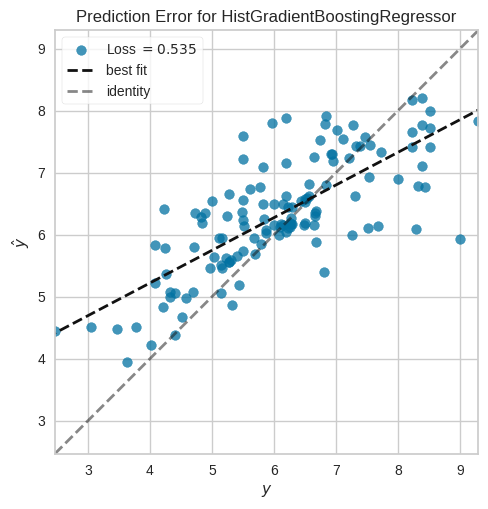

CPU times: user 5.69 s, sys: 1.5 s, total: 7.19 s
Wall time: 7.18 s


In [24]:
%%time
visualizer = prediction_error(model,np.stack(train.fp),train.pIC50,np.stack(test.fp),test.pIC50)

Un R2 de X indica que el modelo explica aproximadamente el X% de la variabilidad en la variable objetivo en el conjunto de prueba. Esto se considera 1) bastante bueno (al ser alto) y sugiere que el modelo tiene un buen poder predictivo. 2) malo (al ser bajo) y sugiere que el modelo tiene un mal poder predictivo

<a name='8'></a>
##**8.** Residuales.
Gráfica los residuales del set de entrenamiento y prueba. Los residuales son la diferencia entre los valores reales de la variable objetivo y las predicciones realizadas por el modelo. Los residuales son una medida de cuánto se desvían las predicciones del modelo de los valores reales. Si un modelo es preciso, los residuales deberían ser cercanos a cero.
Una gran diferencia entre la R2 de entrenamiento y prueba podría indicar sobreajuste (overfitting), donde el modelo se ha adaptado demasiado a los datos de entrenamiento específicos y no generaliza bien a nuevos datos.


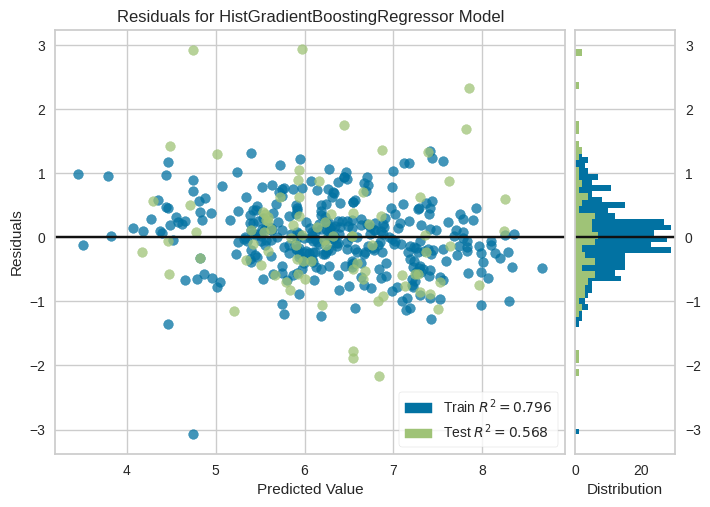

In [11]:
viz = residuals_plot(model,np.stack(train.fp), train.pIC50, np.stack(test.fp), test.pIC50, is_fitted=True)

<a name='9'></a>
##**9.** Predicción.


In [ ]:
#Leer archivo
url = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/Fingerprints.csv"
df_prediction = pd.read_csv(url)
df_prediction=df_prediction[['ID', 'smiles']]
df_prediction

,ID,smiles
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1
...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1


In [ ]:
df_prediction['fp'] = trans.transform(df_prediction.smiles.values)
df_prediction

,ID,smiles,fp
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,ID,smiles,fp,predicted_ic50,ROMol
113,CHEMBL4454542,O(CCCN1CCCC1)c1c(OC)cc2C(NC3CCN(C(C)C)CC3)=NCC...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",7.060800,
60,CHEMBL4162206,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(C...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",7.002007,
99,CHEMBL1231795,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)nc(C...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",6.896079,
20,CHEMBL4204482,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CC4(C3)CCN(C(C)C)C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",6.863930,
34,CHEMBL4173626,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(-...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",6.837579,
...,...,...,...,...,...
154,CHEMBL3109085,S(N[C@](C(=O)O)Cc1c2c([nH]c1)cccc2)c1c([N+](=O...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.641793,
190,Panobinostat,O=C(NO)/C=C/c1ccc(CNCCc2c(C)[nH]c3c2cccc3)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.472556,
193,CSC027694519,O=C(N)c1c(C)cc(NCc2oc(Cc3ccccc3)nn2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.415326,
100,CHEMBL4878570,O=C(NO)C1CCN(CC(O)COC(Cn2c3c(c4c2cccc4)cccc3)C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.412415,

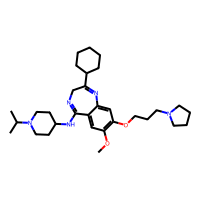
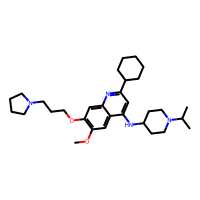
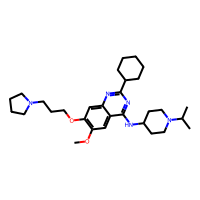
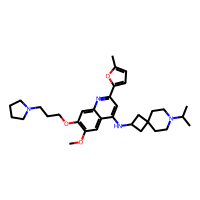
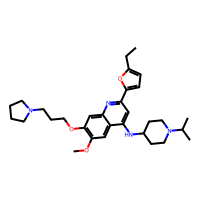
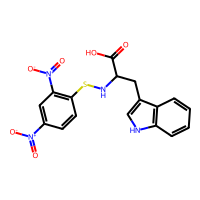
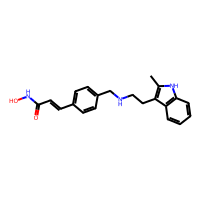
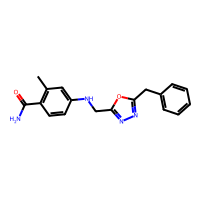
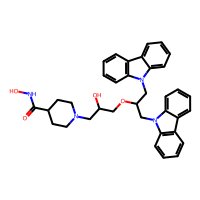
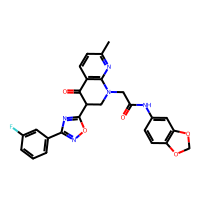

In [ ]:
df_prediction['predicted_ic50'] = model.predict(np.stack(df_prediction.fp))
df_prediction=df_prediction.sort_values(by='predicted_ic50', ascending=False)
df_prediction

,ID,smiles,fp,predicted_ic50,ROMol
113,CHEMBL4454542,O(CCCN1CCCC1)c1c(OC)cc2C(NC3CCN(C(C)C)CC3)=NCC...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",7.060800,
60,CHEMBL4162206,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(C...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",7.002007,
99,CHEMBL1231795,O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)nc(C...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",6.896079,

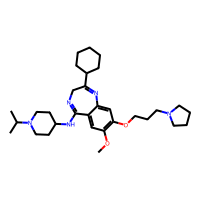
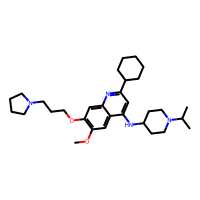
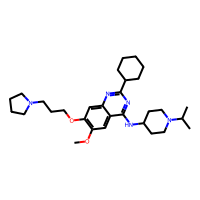

In [ ]:
df_prediction['ROMol'] = df_prediction['smiles'].apply(Chem.MolFromSmiles)#.apply(Chem.AddHs)
df_prediction[0:3]

<a name='10'></a>

# **10.** - Referencias y fuentes de consulta:


*   Script original de Patt Walters: https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/QSAR_in_8_lines.ipynb
* Blog en GitHub de Patt Walters: https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file


